## A Correlational Study of Music Engagement and Earliest Musical Memory Vividness and Emotional Intensity

In this study we investigate the relationships between music engagement of adults and earliest musical memories. In particular, we analyzed if there is any correlation between vividness and emotional intensity of these earliest musical memories and music engagement in adult life. 
Our research question can be defined as follows:
What is the relationship between a person’s engagement with music, and the vividness and emotional intensity of their earliest musical memories?


### The Dataset

To obtain data for our research we conducted a survey with several questions relating to memory, vividness as well as demographic information. The results of our analysis of the 59 responses will be presented in this notebook. Before that, we had to preprocess the data from the survey to make it fit for further analysis. The following figure is showing a brief explanation of the filtering.

![Dataset Extraction](data/img/mpc_methodology.jpg)

In [1]:
# Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset
filepath = 'data/MPC Survey Responses Filtered.xlsx'
df = pd.read_excel(filepath)

# Center plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
df

,Gender,Age,MusicTraining,MusicalityRating,musEQScore,MQ1,MQ2,MQ3,MQ4,MQ5,RecollectionScore,BeliefScore,RehearsalScore,MemoryProvided,Memories
0,Female,Between 21 and 29,more than 9 years,10,4.666667,4 - 6 years,5,4.0,3.0,5,5.666667,6.25,2.5,1,"I was five years old, and I remember very clea..."
1,Male,Between 21 and 29,6 - 8 years,7,3.833333,4 - 6 years,2,4.0,1.0,4,2.000000,5.25,2.0,0,NaN
2,Male,Between 21 and 29,6 - 8 years,8,4.833333,4 - 6 years,3,3.0,3.0,3,4.666667,4.25,5.0,0,NaN
3,Nonbinary,Between 21 and 29,more than 9 years,10,5.000000,2 - 3 years,4,5.0,3.0,5,4.333333,3.50,4.5,0,NaN
4,Male,Between 30 and 39,more than 9 years,7,4.500000,2 - 3 years,2,3.0,2.0,4,3.666667,2.75,4.0,0,NaN
5,Female,50 or more,0 - 2 years,5,2.666667,2 - 3 years,4,1.0,4.0,5,3.000000,4.50,3.0,1,My great uncle came for a visit. He sat at the...
6,Female,20 or below,more than 9 years,7,4.166667,2 - 3 years,3,5.0,2.0,5,2.666667,4.25,1.5,0,NaN
7,Male,Between 21 and 29,0 - 2 years,3,3.166667,4 - 6 years,1,1.0,2.0,3,2.333333,3.00,1.0,0,NaN
8,Nonbinary,Between 21 and 29,0 - 2 years,5,4.000000,2 - 3 years,4,1.0,2.0,5,4.666667,5.75,4.5,1,My first concert - James Taylor at an outdoor ...
9,Female,Between 21 and 29,3 - 5 years,7,4.666667,1/2 years,5,5.0,2.0,5,6.000000,6.00,5.0,0,NaN


### Demographics

In this section we introduce some demographic information of the survey takers. We aimed to reach a diverse population of people with different perspectives towards music to get a balanced representation and explore possible correlations.

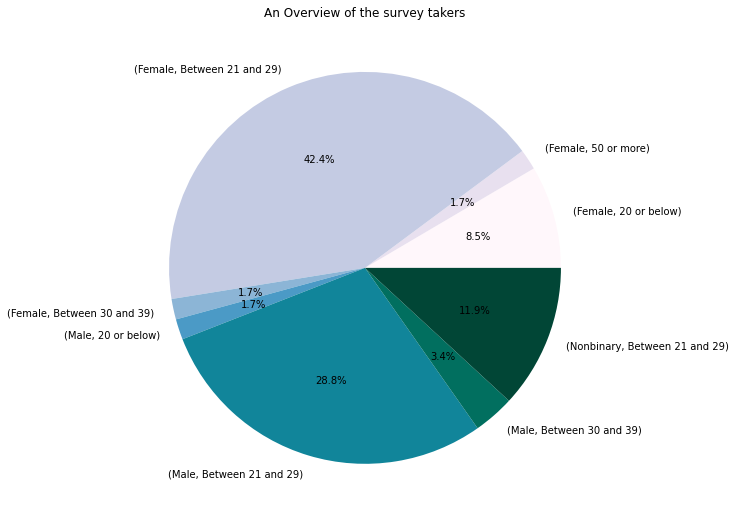

In [11]:
df.groupby(['Gender', 'Age']).size().plot(kind='pie', 
                                          figsize=(10,10), 
                                          ylabel=' ', 
                                          autopct='%1.1f%%', 
                                          title='An Overview of the survey takers',
                                          colormap='PuBuGn')

plt.tight_layout()

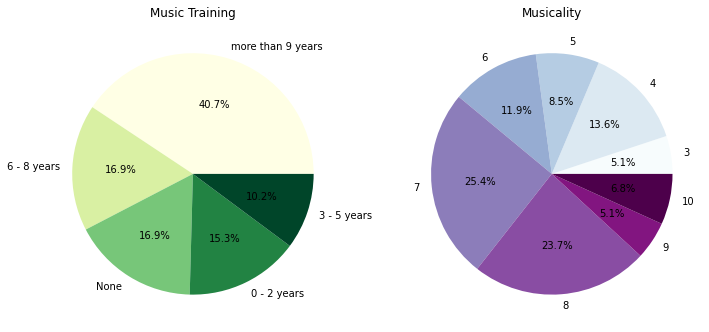

In [36]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

df.MusicTraining.value_counts().plot(
                                     kind='pie',
                                     autopct='%1.1f%%',
                                     colormap='YlGn',
                                     ylabel=' ',
                                     ax=ax[0],
                                     title='Music Training')

df.MusicalityRating.value_counts().sort_index().plot(
                                     kind='pie',
                                     ylabel=' ',
                                     colormap='BuPu',
                                     ax=ax[1],
                                     autopct='%1.1f%%',
                                     title='Musicality')

plt.tight_layout()

### Music Engagement

We now present the scores outcome of the musEQ questionnaire. The musEQ paper can be found [here](DOI:10.1080/13607863.2015.1021750). The original questionnaire contains 35 items for 6 categories which we shrinked down to 8 items for 6 categories to make it fit for the scope of our work. We then used the mean value for each category and obtained the musEQ score which is presented in the following figures.